# Bayesian Forecaster

#### Imports

In [1]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

#### data setup

In [2]:
# importing data
experiment_type = "small"
data_directory = '../data/experiment_' + experiment_type + '/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (2,1, 0))

#reshaping and trimming
data = data.reshape(len(data),2*len(data[0]))
data_test = data[-365:,:]
data_val = data[-3*365:-365,:]
data_train = data[:-3*365,:]

diffs_test = np.diff(data_test, axis=0)
diffs_val = np.diff(data_val, axis=0)
diffs_train = np.diff(data_train, axis=0)

T,D = diffs_train.shape

# creating the dataframe
hospital_list = np.genfromtxt(data_directory + 'network_params/hospitals.txt', dtype=str, delimiter='\n', comments=None)
df_cols = np.array([[h + ' supply',h + ' demand'] for h in hospital_list]).reshape(D)
df_train = pd.DataFrame(diffs_train, columns=df_cols)

df_train

,Orange County supply,Orange County demand,Los Angeles supply,Los Angeles demand,Alta Bates supply,Alta Bates demand,Oakland supply,Oakland demand
0,-0.822526,4.916822,-0.651468,5.990946,-0.181573,1.195645,-0.153877,0.551387
1,-5.102420,-2.577938,-5.759107,-3.141480,-1.605124,-0.864180,-0.954659,-0.499657
2,-6.269205,-12.057078,-7.188447,-14.690660,-2.003511,-3.462579,-1.172944,-1.826633
3,0.079720,2.358417,0.267309,2.874134,0.074500,0.414624,0.014919,0.172501
4,-1.913910,-2.842920,-2.149450,-3.464546,-0.599088,-1.026598,-0.358112,-0.558890
...,...,...,...,...,...,...,...,...
1700,-4.477227,2.448968,-4.135527,3.899951,-1.152622,1.052343,-0.427141,0.540418
1701,0.916913,-12.227958,2.282668,-13.954272,0.636207,-2.929913,0.593405,-1.504606
1702,-0.431906,-0.849498,0.724342,-0.062672,0.201877,0.149546,0.350260,0.076791
1703,-0.229383,-6.185178,1.000272,-6.537077,0.278795,-1.301809,0.395280,-0.668523


#### constructing the BVAR model

In [276]:
def bvar_model(h,df,priors,draws=2000,tune=1000,chains=4,cores=4):
    coords = {
        "lags": np.arange(h)+1,
        "vars": df.columns.tolist(),
        "eqs": df.columns.tolist(),
        "time": [t for t in df.index[h:]]
    }

    with pm.Model(coords=coords) as model:
        # variable setup
        beta = pm.Normal(
            "beta",
            mu=priors["beta"]["mu"],
            sigma=priors["beta"]["sigma"],
            dims=("lags","eqs","vars")
        )
        alpha = pm.Normal(
            "alpha",
            mu=priors["alpha"]["mu"],
            sigma=priors["alpha"]["sigma"],
            dims=("eqs",)
        )
        data_obs = pm.Data(
            "data_obs",
            df.values[h:], 
            dims=("time","eqs"),
        )

        n = df.shape[1]

        # ar step
        ar = []
        for i in range(n):
            ar_i = pm.math.sum([
                pm.math.sum(beta[t,i] * df.values[h-(t+1):-(t+1)],axis=-1)
                for t in range(h)
            ],axis=0)
            ar.append(ar_i)

        mu = alpha + pm.math.stack(ar, axis=-1)
        sigma = pm.HalfNormal(
            "noise",
            sigma=priors["noise"]["sigma"],
            dims=["eqs"]
        )
        obs = pm.Normal(
            "obs",
            mu=mu,
            sigma=sigma,
            observed=data_obs,
            dims=["time","eqs"]
            )

        #sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            cores=cores,
            random_seed=420,
            target_accept=0.95,
            sample='numpyro'
        )
    return model,trace

In [277]:
h = 3
draws=2000
tune=4000
chains=4
cores=4

priors = {
    "beta": {"mu": 0.0, "sigma": 10.0},
    "alpha": {"mu": 0.0, "sigma": 10.0},
    "noise": {"sigma": 10.0}
}

model_new, trace_new = bvar_model(h, df_train, priors,draws=draws,tune=tune,chains=chains,cores=cores)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, noise]


Output()

ValueError: Not enough samples to build a trace.

#### looking at the model

In [5]:
az.summary(trace, var_names=["alpha", "beta","noise"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Orange County supply],-0.039,0.138,-0.305,0.203,0.014,0.010,101.0,324.0,1.06
alpha[Orange County demand],-0.040,0.151,-0.339,0.231,0.009,0.006,289.0,605.0,1.01
alpha[Los Angeles supply],-0.052,0.155,-0.355,0.245,0.014,0.010,119.0,275.0,1.03
alpha[Los Angeles demand],-0.015,0.151,-0.286,0.279,0.011,0.008,195.0,379.0,1.01
alpha[Alta Bates supply],-0.014,0.044,-0.098,0.067,0.004,0.003,151.0,263.0,1.02
...,...,...,...,...,...,...,...,...,...
noise[Los Angeles demand],6.307,0.103,6.102,6.485,0.010,0.007,102.0,255.0,1.05
noise[Alta Bates supply],1.850,0.031,1.792,1.912,0.002,0.002,183.0,455.0,1.02
noise[Alta Bates demand],1.628,0.029,1.575,1.681,0.002,0.001,197.0,509.0,1.03
noise[Oakland supply],0.843,0.014,0.815,0.868,0.001,0.001,148.0,394.0,1.02


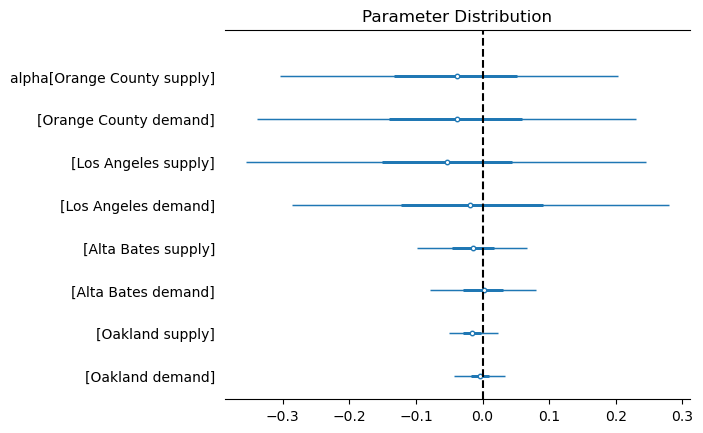

In [6]:
#fig, ax = plt.subplots(figsize=(20, 100))
az.plot_forest(trace, var_names=["alpha"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Parameter Distribution");

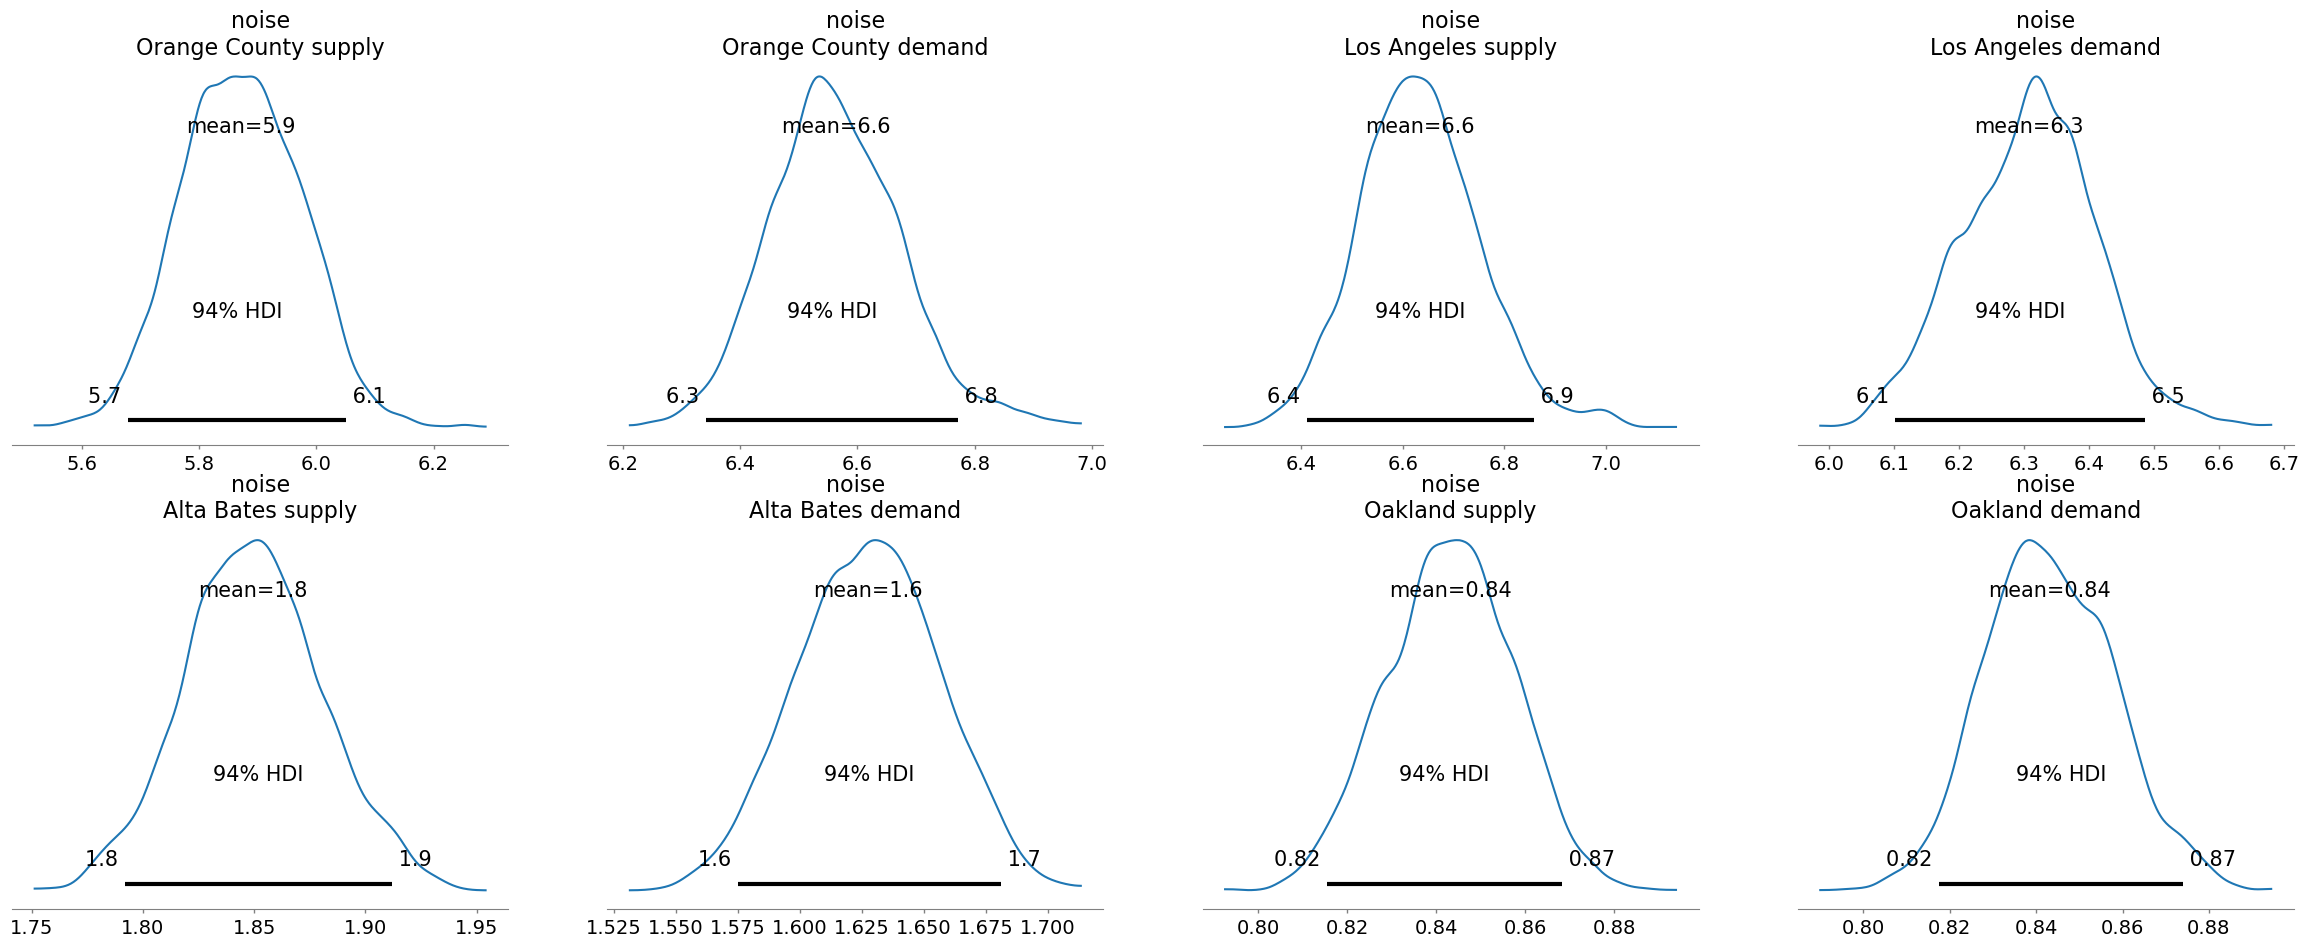

In [7]:
az.plot_posterior(trace, var_names=["noise"]);

#### forecasting

In [31]:
def _forecast(data,alpha,beta,noise,f):
    len_data = len(data)
    h = len(beta)
    data_forecast = np.zeros((data.shape[0]+f,data.shape[1]))
    data_forecast[:len_data] = data[:]

    for t in range(f):
        ar = []
        for n in range(data.shape[1]):
            ar_n = np.sum(beta[:,n]*data_forecast[len_data+t-h:len_data+t])
            ar.append(ar_n)
        mu = alpha + np.stack(ar,axis=-1)
        data_forecast[len_data+t] = np.random.normal(mu,noise)
    data_forecast[:-f-1] = np.nan
    return data_forecast

forecast = np.vectorize(
    _forecast,
    signature=("(T,D),(D),(H,D,D),(D)->(F,D)"),
    excluded=("f"),
)

In [238]:
size = 4000
sample_indices = np.random.randint(draws*chains,size=size)
post = trace.posterior.stack(sample=("chain","draw"))
alpha_draws = post["alpha"].values.T[sample_indices]
beta_draws = post["beta"].values.T[sample_indices].T
beta_draws = np.moveaxis(beta_draws,-1,0)
noise_draws = post["noise"].values.T[sample_indices]

alpha_avg=np.mean(alpha_draws,axis=0)
beta_avg=np.mean(beta_draws,axis=0)
noise_avg=np.mean(noise_draws,axis=0)

In [239]:
f=3
forecast_draws = forecast(diffs_train,alpha_draws,beta_draws,noise_draws,f=f)
forecast_draws_mean = _forecast(diffs_train,alpha_avg,beta_avg,noise_avg,f=f)

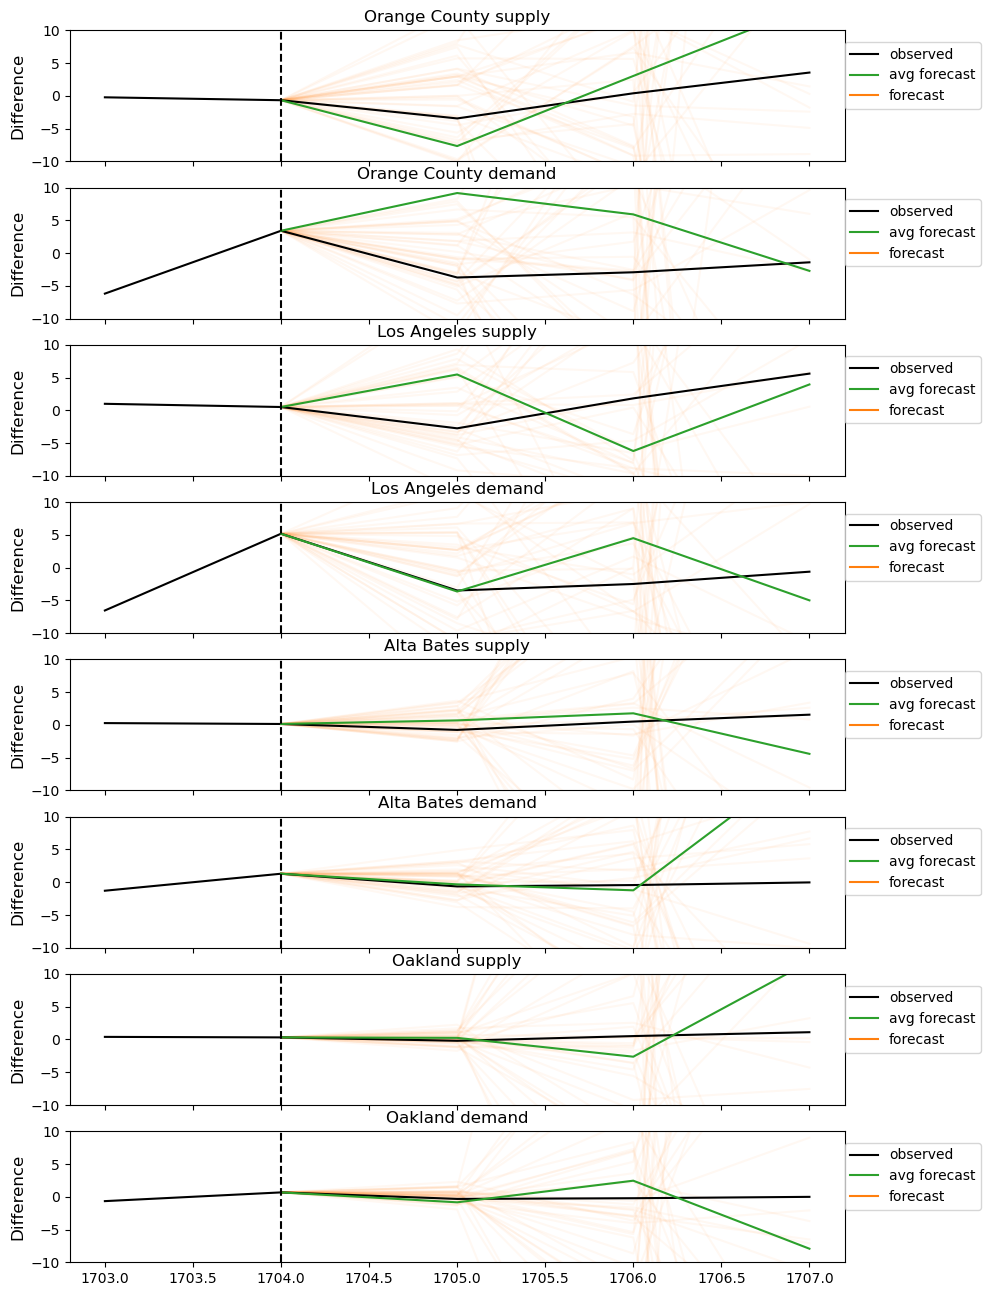

In [240]:
_, ax = plt.subplots(D, 1, sharex=True,figsize=(10,2*D))
times = np.arange(len(diffs_train)+f)
diff = np.diff(data, axis=0)
stagger = 1703

for n in range(D):
    ax[n].set_title(df_cols[n])

    for i in range(forecast_draws.shape[0]):
        if i%100==0:
            ax[n].plot(times[stagger:], forecast_draws[i,stagger:,n], color="C1", alpha=0.05)

    ax[n].set_ylim(-10, 10)
    ax[n].plot(times[stagger:],diff[stagger:len(diffs_train)+f,n], color="k", label="observed")
    ax[n].plot(times[stagger:], forecast_draws_mean[stagger:,n], color="C2",label="avg forecast")
    ax[n].plot([], color="C1", label="forecast")

for axi in ax:
    axi.axvline(len(times)-f-1, ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    axi.set_ylabel("Difference", fontsize=12)

In [16]:
trace.to_netcdf('trace.nc')

'trace.nc'

#### formatting functions for the shapes

In [264]:
def fit_bayesian_forecast()

def get_bayesian_forecast(trace,history,sample_size=100,f=3):
    chains, draws = trace.posterior.sizes["chain"],trace.posterior.sizes["draw"]
    sample_indices = np.random.randint(draws*chains,size=size)
    post = trace.posterior.stack(sample=("chain","draw"))
    alpha_draws = post["alpha"].values.T[sample_indices]
    beta_draws = post["beta"].values.T[sample_indices].T
    beta_draws = np.moveaxis(beta_draws,-1,0)
    noise_draws = post["noise"].values.T[sample_indices]

    alpha_avg=np.median(alpha_draws,axis=0)
    beta_avg=np.median(beta_draws,axis=0)
    noise_avg=np.median(noise_draws,axis=0)

    N,h,_ = history.shape
    history_resh = history.transpose(1,0,2).reshape(h,2*N)
    history_resh_diff = np.diff(history_resh,axis=0)

    forecast_avg = _forecast(history_resh_diff,alpha_avg,beta_avg,noise_avg,f=f)
    forecast_avg = forecast_avg[-f:,:]
    forecast_avg = history_resh[-1,:] + np.cumsum(forecast_avg,axis=0)
    return forecast_avg.reshape(forecast_avg.shape[0],forecast_avg.shape[1]//2,2).transpose(1,0,2)

In [271]:
history = data_train[-h-1:,:]
history = history.reshape(h+1,history.shape[1]//2,2).transpose(1,0,2)

test = get_bayesian_forecast(trace,history,f=f,sample_size=2000)

In [272]:
test[0]

array([[122.08734167, 167.06907907],
       [134.9247552 , 176.3778116 ],
       [131.33668886, 206.48876934]])

In [274]:
data_val[:3,0]

array([115.91454593, 116.29780537, 119.84547952])